# Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [682]:
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from mdp import MDP, has_graphviz, FrozenLakeEnv
from IPython.display import display, clear_output

%matplotlib inline

In [683]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [684]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [685]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. For ubuntu just run:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. restart the notebook

For windows this might work: `conda install -c conda-forge python-graphviz`. However, you can ignore this part alltogether and use the standard vizualization.

In [686]:
print("Graphviz available:", has_graphviz)

Graphviz available: True


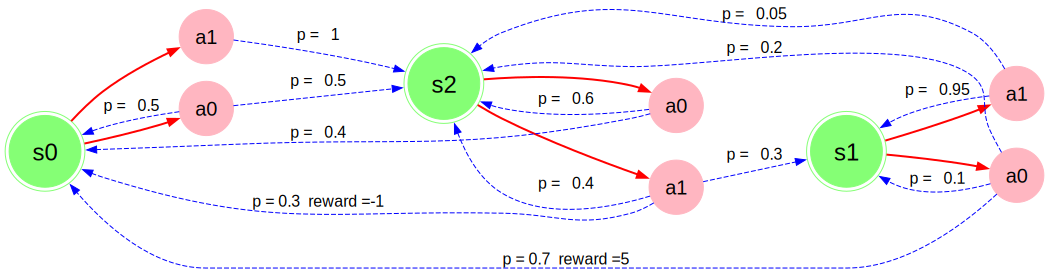

In [687]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, \
        plot_graph_optimal_strategy_and_state_values

    display(plot_graph(mdp))

# Value Iteration (up to 1 point)

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max\limits_a \sum\limits_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^*$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [768]:
%%writefile mdp_get_action_value.py


def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    q_i = 0
    for next_state in state_values:

        reward = mdp.get_reward(state, action, next_state)

        q_i += (reward + gamma * state_values[next_state]) * mdp.get_transition_prob(state, action, next_state)
    

    return q_i

Overwriting mdp_get_action_value.py


In [689]:
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [769]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0
    v = 0
    for action in mdp.get_possible_actions(state):
        action_value = get_action_value(mdp, state_values, state, action, gamma)
        if v < action_value:
            v = action_value

    return v

In [691]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert test_Vs == test_Vs_copy, "please do not change state_values in get_new_state_value"

Finally, let's combine everything we wrote into a working value iteration algo.

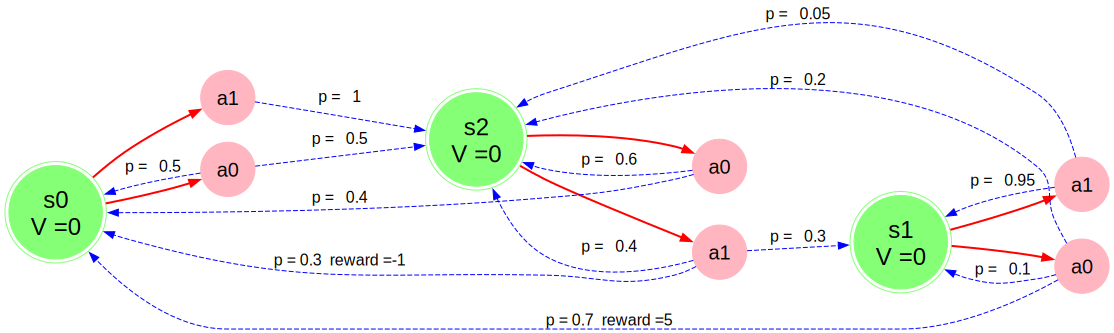

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [770]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {}

    for state in mdp.get_all_states():
        new_state_values[state] = get_new_state_value(mdp, state_values, state, gamma)

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

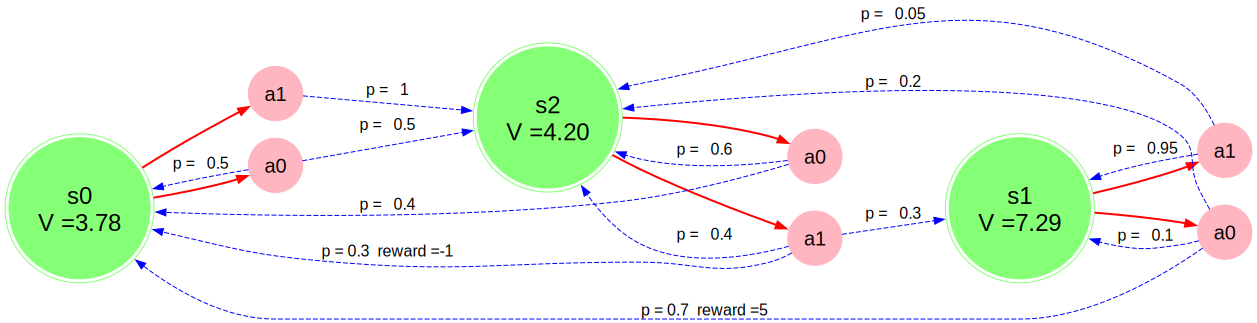

In [693]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [694]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = \underset{a}{\operatorname{argmax}} \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \underset{a}{\operatorname{argmax}} Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [771]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    v = 0
    optimal_action = mdp.get_possible_actions(state)[0]
    for action in mdp.get_possible_actions(state):
        action_value = get_action_value(mdp, state_values, state, action, gamma)
        if v < action_value:
            v = action_value
            optimal_action = action

    return optimal_action


In [696]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

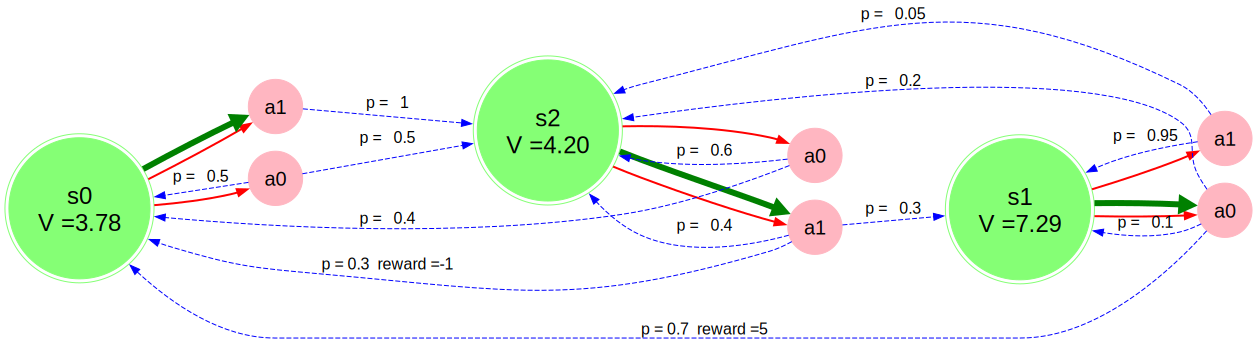

In [697]:
if has_graphviz:
    try:
        display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))
    except ImportError:
        raise ImportError("Run the cell that starts with \"%%writefile mdp_get_action_value.py\"")

In [772]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4806


### Frozen lake

In [699]:
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [700]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {}

        for state in mdp.get_all_states():
            new_state_values[state] = get_new_state_value(mdp, state_values, state, gamma)

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [701]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [702]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [703]:


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


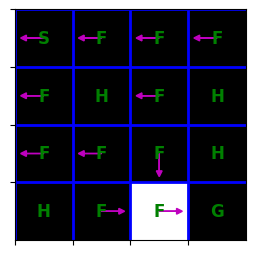

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


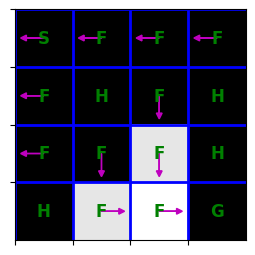

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


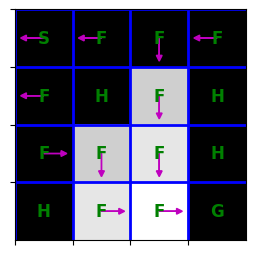

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


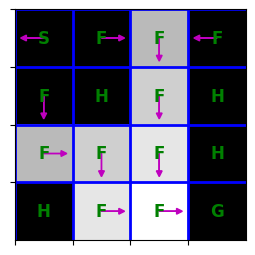

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


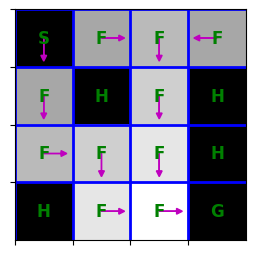

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


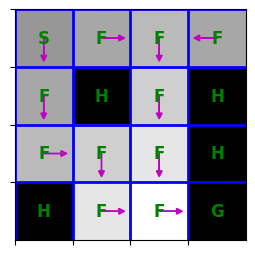

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 


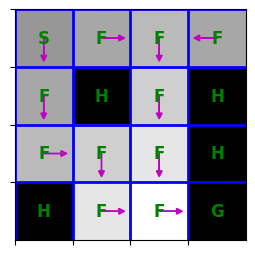

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 


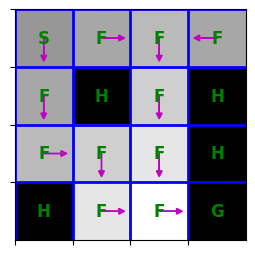

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 


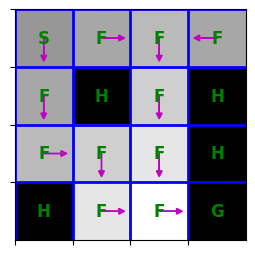

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 


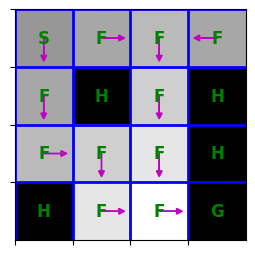

In [704]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


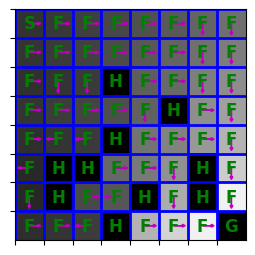

In [705]:
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [706]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
average reward:  1.0
Well done!


In [707]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
average reward:  0.881
Well done!


In [708]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 

In [709]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

# Policy Iteration (up to 1 points)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \underset{a}{\operatorname*{argmax}} Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [710]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve` or fixed-point iteration method.)

In [775]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    states = mdp.get_all_states()
    state_idx = {s: i for i, s in enumerate(mdp.get_all_states())}
    idx_state = {i: s for i, s in enumerate(mdp.get_all_states())}

    n = len(policy)
    a, b = np.eye(n), np.zeros(n)


    
    for state in states:
        if mdp.is_terminal(state):
            prob = 1
            next_state = state
            i = state_idx[state]
            j = state_idx[next_state]
            a[i, j] -= gamma
            b[i] += 0
        else:
            i = state_idx[state]
            if state in policy:
                action = policy[state]
                for next_state, prob in mdp.get_next_states(state, action).items():
                    j = state_idx[next_state]
                    a[i, j] -= gamma * prob
                    b[i] += mdp.get_reward(state, action, next_state) * prob
    vpi = np.linalg.solve(a, b)


    return {idx_state[i]: s for i, s in enumerate(vpi)}
    

In [713]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 0.0, 's1': 3.846153846153846, 's2': 0.0}


Once we've got new state values, it's time to update our policy.

In [776]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    new_policy = {}
    for state in mdp.get_all_states():
        new_policy[state] = get_optimal_action(mdp, vpi, state, gamma)
    
    return new_policy
        
        

In [715]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a0', 's1': 'a0', 's2': 'a1'}


__Main loop__

In [777]:
import time

def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=10000, min_difference=1e-4):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.

    """

    if policy is None:
        policy = {}
        for s in mdp.get_all_states():
            possible_actions = mdp.get_possible_actions(s)
            if len(possible_actions) != 0:
                policy[s] = np.random.choice(possible_actions)
            else:
                policy[s] = None
    
    new_vpi = compute_vpi(mdp, policy, gamma)
                    
    for i in range(1, num_iter + 1):

        old_vpi = compute_vpi(mdp, policy, gamma)
        new_policy = compute_new_policy(mdp, old_vpi, gamma)

        new_policy = {k: v for k, v in new_policy.items()}

        res = all((new_policy.get(k) == v for k, v in policy.items()))
        if res:
            print("iter %4i    V(start): %.3f " %
                (i, new_vpi[mdp._initial_state]))
            break
        
        policy = new_policy
        new_vpi = compute_vpi(mdp, policy, gamma)
        diff = max(abs(old_vpi[i] - new_vpi[i]) for i in mdp.get_all_states())
        if diff < min_difference:
            print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
                (i, diff, new_vpi[mdp._initial_state]))
            break



    return new_vpi, policy

In [739]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

state_values, policy = policy_iteration(mdp, test_policy)

iter    2    V(start): 3.790 


__Your PI Results__

### Default MDP:

In [778]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

In [779]:
s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("value iteration average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

value iteration average reward:  0.4628


In [780]:
state_values, policy = policy_iteration(mdp, num_iter=30)

iter    1    V(start): 3.790 


iter    3    V(start): 3.790 


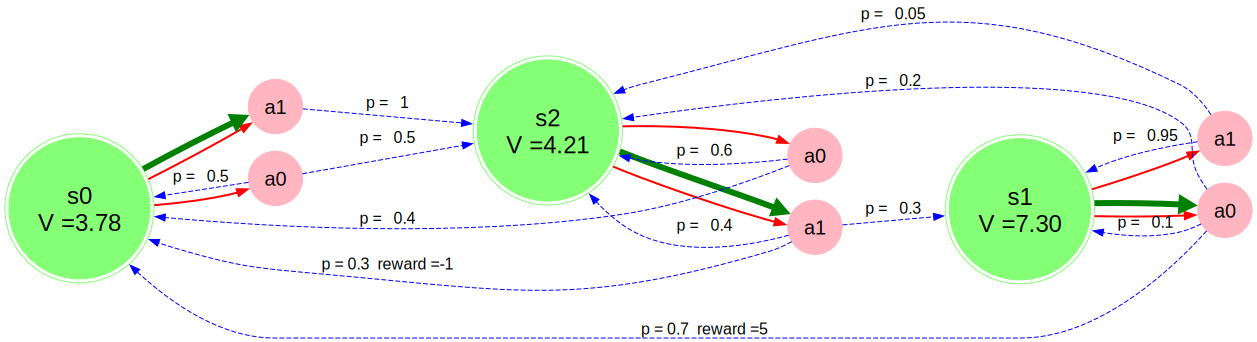

CPU times: user 4.08 ms, sys: 8.77 ms, total: 12.9 ms
Wall time: 221 ms


In [781]:
%%time
policy_iteration(mdp)
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))

iter    0   |   diff: 3.50000   |   V(start): 0.000 
iter    1   |   diff: 0.64500   |   V(start): 0.000 
iter    2   |   diff: 0.58050   |   V(start): 0.581 
iter    3   |   diff: 0.43582   |   V(start): 0.866 
iter    4   |   diff: 0.30634   |   V(start): 1.145 
iter    5   |   diff: 0.27571   |   V(start): 1.421 
iter    6   |   diff: 0.24347   |   V(start): 1.655 
iter    7   |   diff: 0.21419   |   V(start): 1.868 
iter    8   |   diff: 0.19277   |   V(start): 2.061 
iter    9   |   diff: 0.17327   |   V(start): 2.233 
iter   10   |   diff: 0.15569   |   V(start): 2.389 
iter   11   |   diff: 0.14012   |   V(start): 2.529 
iter   12   |   diff: 0.12610   |   V(start): 2.655 
iter   13   |   diff: 0.11348   |   V(start): 2.769 
iter   14   |   diff: 0.10213   |   V(start): 2.871 
iter   15   |   diff: 0.09192   |   V(start): 2.963 
iter   16   |   diff: 0.08272   |   V(start): 3.045 
iter   17   |   diff: 0.07445   |   V(start): 3.120 
iter   18   |   diff: 0.06701   |   V(start): 

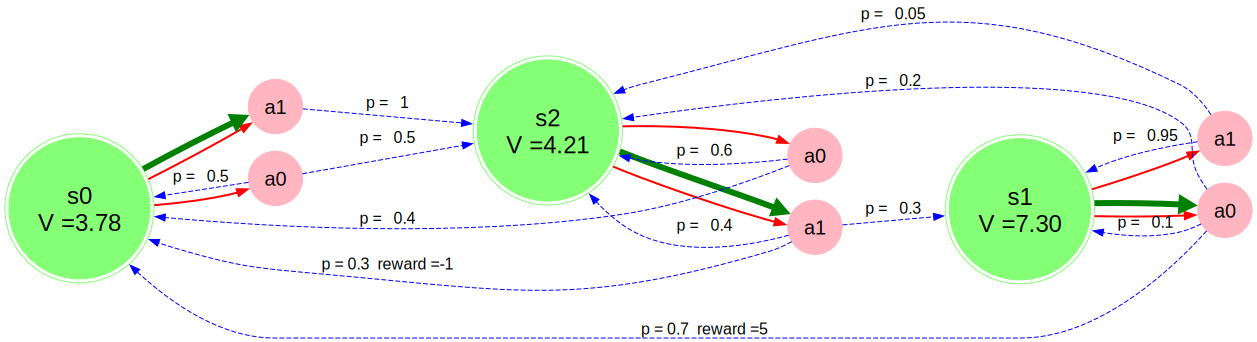

CPU times: user 5.8 ms, sys: 8.69 ms, total: 14.5 ms
Wall time: 161 ms


In [782]:
%%time
value_iteration(mdp)
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))

Required only 3 iterations with PI to converge and 102 with VI to converge.

### Frozen Lake small dataset

In [745]:
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



### test 1

#### Comparing the number of iterations to converge
In this case PI and VI require seemingly the same number of iterations to converge (6-7)

In [802]:
%%time
mdp = FrozenLakeEnv(slip_chance=0)
value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
CPU times: user 5.14 ms, sys: 1.71 ms, total: 6.85 ms
Wall time: 6.49 ms


{(0, 0): 0.5904900000000002,
 (0, 1): 0.6561000000000001,
 (0, 2): 0.7290000000000001,
 (0, 3): 0.6561000000000001,
 (1, 0): 0.6561000000000001,
 (1, 1): 0,
 (1, 2): 0.81,
 (1, 3): 0,
 (2, 0): 0.7290000000000001,
 (2, 1): 0.81,
 (2, 2): 0.9,
 (2, 3): 0,
 (3, 0): 0,
 (3, 1): 0.9,
 (3, 2): 1.0,
 (3, 3): 0}

In [803]:
%%time
mdp = FrozenLakeEnv(slip_chance=0)
policy_iteration(mdp)

iter    7    V(start): 0.590 
CPU times: user 9.96 ms, sys: 950 µs, total: 10.9 ms
Wall time: 10.7 ms


({(0, 0): 0.5904900000000002,
  (0, 1): 0.6561000000000001,
  (0, 2): 0.7290000000000001,
  (0, 3): 0.6561000000000001,
  (1, 0): 0.6561000000000001,
  (1, 1): 0.0,
  (1, 2): 0.81,
  (1, 3): 0.0,
  (2, 0): 0.7290000000000001,
  (2, 1): 0.81,
  (2, 2): 0.9,
  (2, 3): 0.0,
  (3, 0): 0.0,
  (3, 1): 0.9,
  (3, 2): 1.0,
  (3, 3): 0.0},
 {(0, 0): 'down',
  (0, 1): 'right',
  (0, 2): 'down',
  (0, 3): 'left',
  (1, 0): 'down',
  (1, 1): None,
  (1, 2): 'down',
  (1, 3): None,
  (2, 0): 'right',
  (2, 1): 'down',
  (2, 2): 'down',
  (2, 3): None,
  (3, 0): None,
  (3, 1): 'right',
  (3, 2): 'right',
  (3, 3): None})

##### Passing the tests here

In [790]:
%%time
## policy iteration
mdp = FrozenLakeEnv(slip_chance=0)

state_values = {s: 0 for s in mdp.get_all_states()}

policy = {}

for s in mdp.get_all_states():
    if mdp.is_terminal(s):
        policy[s] = None
    else:
        actions = mdp.get_possible_actions(s)
        policy[s] = np.random.choice(actions)
        

    

total_rewards = []
iteration_end = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        state_values, policy = policy_iteration(mdp, policy)
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
       
        rewards.append(r)
    total_rewards.append(np.sum(rewards))

print("policy iteration average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    7    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1    V(start): 0.590 
iter    1 

### test 2

#### Comparing the number of iterations to converge
TLDR: VI: 16 iterations
PI: 3 iterations

In [804]:
%%time
mdp = FrozenLakeEnv(slip_chance=0.1)
value_iteration(mdp)

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
CPU times: user 13.1 ms, sys: 6.97 ms, total: 20.1 ms
Wall time: 42.7 ms


{(0, 0): 0.4901777915136051,
 (0, 1): 0.4998574543564074,
 (0, 2): 0.589338609277083,
 (0, 3): 0.4998574543564074,
 (1, 0): 0.5501578116291514,
 (1, 1): 0,
 (1, 2): 0.6720390768399604,
 (1, 3): 0,
 (2, 0): 0.6486433930909553,
 (2, 1): 0.7702302720200231,
 (2, 2): 0.8296778974438127,
 (2, 3): 0,
 (3, 0): 0,
 (3, 1): 0.8687726660616404,
 (3, 2): 0.9815031455811786,
 (3, 3): 0}

In [805]:
%%time
mdp = FrozenLakeEnv(slip_chance=0.1)
policy_iteration(mdp)

iter    3    V(start): 0.490 
CPU times: user 3.71 ms, sys: 1.89 ms, total: 5.59 ms
Wall time: 5.85 ms


({(0, 0): 0.49018014472142285,
  (0, 1): 0.4998581352257084,
  (0, 2): 0.5893389125191993,
  (0, 3): 0.4998581352257085,
  (1, 0): 0.5501585458318542,
  (1, 1): 0.0,
  (1, 2): 0.672039111541834,
  (1, 3): 0.0,
  (2, 0): 0.6486437176165688,
  (2, 1): 0.7702303494495497,
  (2, 2): 0.8296779154837457,
  (2, 3): 0.0,
  (3, 0): 0.0,
  (3, 1): 0.8687726863704144,
  (3, 2): 0.9815031478500196,
  (3, 3): 0.0},
 {(0, 0): 'down',
  (0, 1): 'right',
  (0, 2): 'down',
  (0, 3): 'left',
  (1, 0): 'down',
  (1, 1): None,
  (1, 2): 'down',
  (1, 3): None,
  (2, 0): 'right',
  (2, 1): 'down',
  (2, 2): 'down',
  (2, 3): None,
  (3, 0): None,
  (3, 1): 'right',
  (3, 2): 'right',
  (3, 3): None})

#### Passing the tests here

In [809]:
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

policy = {}

for s in mdp.get_all_states():
    if mdp.is_terminal(s):
        policy[s] = None
    else:
        actions = mdp.get_possible_actions(s)
        policy[s] = np.random.choice(actions)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        state_values, policy = policy_iteration(mdp, policy)
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    3    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1    V(start): 0.490 
iter    1 

### test 3

#### Comparing the number of iterations to converge
TLDR: VI: 33 iterations
PI: 8 iterations

In [811]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
value_iteration(mdp)

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

{(0, 0): 0.1407750491895669,
 (0, 1): 0.1609766628590319,
 (0, 2): 0.18400294705963113,
 (0, 3): 0.2101741521168836,
 (0, 4): 0.23962656155462114,
 (0, 5): 0.27001993585025647,
 (0, 6): 0.3036218462096403,
 (0, 7): 0.3374123930926256,
 (1, 0): 0.13558636173331204,
 (1, 1): 0.1556327287405064,
 (1, 2): 0.17908253092285126,
 (1, 3): 0.20808244538218978,
 (1, 4): 0.26273168163433336,
 (1, 5): 0.30122700703010014,
 (1, 6): 0.34576798077851295,
 (1, 7): 0.38849905087170644,
 (2, 0): 0.12068830471630788,
 (2, 1): 0.13561970757722913,
 (2, 2): 0.14114488040787335,
 (2, 3): 0,
 (2, 4): 0.26979852032563906,
 (2, 5): 0.3108030665149874,
 (2, 6): 0.394017555209199,
 (2, 7): 0.44779863863799874,
 (3, 0): 0.11535950595235797,
 (3, 1): 0.13230274629262265,
 (3, 2): 0.15238861959179562,
 (3, 3): 0.17899575805275128,
 (3, 4): 0.24860522072839183,
 (3, 5): 0,
 (3, 6): 0.4498157631654123,
 (3, 7): 0.51671553023092,
 (4, 0): 0.10267522382594854,
 (4, 1): 0.11530652422085817,
 (4, 2): 0.12009711025336885,

In [810]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
policy_iteration(mdp)

iter    8    V(start): 0.141 


({(0, 0): 0.1407764846564591,
  (0, 1): 0.16097730081029923,
  (0, 2): 0.18400323246850372,
  (0, 3): 0.21017428963200185,
  (0, 4): 0.23962663340798457,
  (0, 5): 0.2700199738494558,
  (0, 6): 0.30362186638128486,
  (0, 7): 0.33741240365031555,
  (1, 0): 0.13558827171069252,
  (1, 1): 0.15563351511166207,
  (1, 2): 0.17908281123663383,
  (1, 3): 0.20808252790414206,
  (1, 4): 0.26273172477397483,
  (1, 5): 0.3012270267608856,
  (1, 6): 0.345767989453202,
  (1, 7): 0.38849905464926593,
  (2, 0): 0.12069174679127193,
  (2, 1): 0.13562148831509743,
  (2, 2): 0.14114555803873524,
  (2, 3): 0.0,
  (2, 4): 0.2697985388824288,
  (2, 5): 0.3108030745347681,
  (2, 6): 0.3940175585087338,
  (2, 7): 0.44779863983339413,
  (3, 0): 0.11536207150971542,
  (3, 1): 0.1323036767818419,
  (3, 2): 0.15238884420787058,
  (3, 3): 0.17899575990190403,
  (3, 4): 0.2486052220859778,
  (3, 5): 0.0,
  (3, 6): 0.4498157641989096,
  (3, 7): 0.5167155305313924,
  (4, 0): 0.10267963350638612,
  (4, 1): 0.115308611

In [814]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = {s: 0 for s in mdp.get_all_states()}

policy = {}

for s in mdp.get_all_states():
    if mdp.is_terminal(s):
        policy[s] = None
    else:
        actions = mdp.get_possible_actions(s)
        policy[s] = np.random.choice(actions)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        state_values, policy = policy_iteration(mdp, policy)
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    9    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1    V(start): 0.141 
iter    1 

### Comparison of VI and PI
I would say that PI converges on average a bit faster than VI which is logical as PI requires less computations and VI is just simply computationally heavier. PI requires a bit less iterations to converge while giving away the same/better quality

# Find an MDP for which value iteration takes long to converge  (up to 0.5 points)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6 -- i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions -- we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here -- you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

Note: by default `initial state` is selected randomly, you might want to change this.

### Answer
Logic behind this mdp: we have 3 states and 2 actions here. For 2 out of 3 states we have the deterministic actions which lead us to that state, but with state_0 we have actions 0 and 1 with probablities 1 which can lead us to state_1 and state 1.

The transition will happen because of the actions we can take in state 0. So here, after 50 iterations we most probably start exploring our ways through the space and take action 1 for a change, when before (iter <= 50) we have converged to another greedy policy

In [ ]:
transition_probs = {
    's0': {
        'a0': {'s0': 1},
        'a1': {'s1': 1}
    },
    's1': {
        'a0': {'s1': 1}
    },
    's2': {
        'a0': {'s0': 1}
    }
}

rewards = {
    's0': {'a0': {'s0': 1}, 'a1': {'s1': -8 + 0.001}},
    's1': {'a0': {'s1': 2}},
    's2': {'a0': {'s0': 0}}
}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))

# Feel free to change the initial_state

In [ ]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(1000):
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    if n_changes > 0:
        print(policy)
        print(new_policy)
        print("after iteration %i" % i)
        print("N actions changed = %i \n" % n_changes)
    
    policy = new_policy

# please ignore iter 0 at each step

['a0' 'a0' 'a0']
['a1' 'a0' 'a0']
after iteration 86
N actions changed = 1 

